<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/master/CorEx_Amazon2014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mounting the drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

##All Imports go here but first, installations

In [0]:
!pip install corextopic
!pip install joblib
!pip install pyLDAvis

In [0]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import pandas as pd

import string

from corextopic import corextopic as ct
from corextopic import vis_topic as vt 
from sklearn.feature_extraction.text import CountVectorizer



pd.set_option('display.max_colwidth', -1)  # to view entire text in any column
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import gzip
from pprint import pprint

from bs4 import BeautifulSoup
import nltk
from nltk import FreqDist
nltk.download('stopwords') 
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer  # alternative lemmatizer
# lemma = WordNetLemmatizer()

import spacy
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim   # for visualizing found topics

import os


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning) 
%matplotlib inline

##Reading the already new Amazon data

In [0]:
import pandas as pd  #This function has changed since the last curated data.
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [0]:
df = getDF('/content/drive/My Drive/Amazon_data/Patio_Lawn_and_Garden.json.gz') #Change to your file path

In [0]:
meta_df = pd.read_csv('/content/drive/My Drive/Amazon_data/metadata.csv') #Change to your file path
merged_df = pd.merge(df, meta_df, how='inner', on=['asin'])

In [147]:
#Some analysis -- not to be run for the file
merged_df.columns
merged_df_2 = merged_df.drop(columns = ['overall', 'vote', 'verified', 'reviewTime', 'reviewerID',
       'style', 'reviewerName',  'summary', 'unixReviewTime',
       'image_x', 'Unnamed: 0', 'category',  'description', 
       'also_buy', 'brand', 'feature', 'rank',  'date', 'price',
       'image_y', 'also_view', 'similar_item', 'details', 'fit', 'tech2'])
print(merged_df_2.shape)
merged_df_2['COUNTER'] = 1
group_data = merged_df_2.groupby(['main_cat'])['COUNTER'].sum()
print(group_data)

(5431771, 5)
main_cat
All Beauty                      4965   
All Electronics                 4054   
Amazon Home                     4957515
Appliances                      171    
Arts, Crafts & Sewing           5967   
Automotive                      48438  
Baby                            2598   
Books                           1889   
Buy a Kindle                    85     
Camera & Photo                  1230   
Car Electronics                 117    
Cell Phones & Accessories       4617   
Computers                       898    
GPS & Navigation                8      
Grocery                         14920  
Health & Personal Care          17594  
Home Audio & Theater            1007   
Industrial & Scientific         68833  
Movies & TV                     56     
Musical Instruments             590    
Office Products                 7350   
Pet Supplies                    53695  
Portable Audio & Accessories    38     
Sports & Outdoors               101918 
Tools & Home Impro

In [107]:
print('Shape of the merged dataframe is ', merged_df.shape)

merged_df['COUNTER'] =1       #initially, set that counter to 1.
group_data = merged_df.groupby(['overall'])['COUNTER'].sum() #sum function
print(group_data)
print('----------------------------- After slimming down the data ----------------------------')
merged_df = merged_df.head(500000) #In order to slim down the data from 5 million to 500k for better and time-efficient pre-processing
print('Shape after the data slimming down ',merged_df.shape)
merged_df['COUNTER'] =1       #initially, set that counter to 1.
group_data = merged_df.groupby(['overall'])['COUNTER'].sum() #sum function
print(group_data)



Shape of the merged dataframe is  (5431771, 30)
overall
1.0    612922 
2.0    276999 
3.0    378650 
4.0    751360 
5.0    3411840
Name: COUNTER, dtype: int64
----------------------------- After slimming down the data ----------------------------
Shape after the data slimming down  (500000, 31)
overall
1.0    51271 
2.0    25559 
3.0    35936 
4.0    75975 
5.0    311259
Name: COUNTER, dtype: int64


In [101]:
merged_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image_x', 'Unnamed: 0', 'category', 'tech1', 'description', 'title',
       'also_buy', 'brand', 'feature', 'rank', 'main_cat', 'date', 'price',
       'image_y', 'also_view', 'similar_item', 'details', 'fit', 'tech2'],
      dtype='object')

In [74]:
#Not to be run for the file
matching = [s for s in merged_df.summary if "good" in s]
matching
print('Common number of elements found ', len(matching))

Common number of elements found  30086


In [148]:
#Class balancing of the review -- This needs to be run
merged_df = merged_df.groupby('overall').head(60000).reset_index(drop=True)
print('Shape after class balancing  ',merged_df.shape)
merged_df['COUNTER'] =1       #initially, set that counter to 1.
group_data = merged_df.groupby(['overall'])['COUNTER'].sum() #sum function
print(group_data)

print('----------- Checking the main_categories present------------')
merged_df['COUNTER'] =1       #initially, set that counter to 1.
group_data = merged_df.groupby(['main_cat'])['COUNTER'].sum() #sum function
print(group_data)

Shape after class balancing   (300000, 30)
overall
1.0    60000
2.0    60000
3.0    60000
4.0    60000
5.0    60000
Name: COUNTER, dtype: int64
----------- Checking the main_categories present------------
main_cat
All Beauty                   76    
All Electronics              72    
Amazon Home                  277547
Arts, Crafts & Sewing        76    
Automotive                   3178  
Baby                         57    
Books                        48    
Camera & Photo               1     
Cell Phones & Accessories    10    
Grocery                      764   
Health & Personal Care       510   
Home Audio & Theater         34    
Industrial & Scientific      3138  
Musical Instruments          26    
Office Products              200   
Pet Supplies                 4883  
Sports & Outdoors            3864  
Tools & Home Improvement     3243  
Toys & Games                 2244  
Name: COUNTER, dtype: int64


##Building Dictionary,Term-Doc Matrix

In [110]:
cat_list= list(merged_df.category.astype(str).str.lower().unique())
print(type(cat_list))
print('length of the list', len(cat_list))
#cat_list

<class 'list'>
length of the list 560


##CorEx for the Theme of the review

In [0]:
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

#First, let's remove the stopwords
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(cat_list) 
merged_df['summary'] = merged_df['summary'].astype(str) 
merged_df['summary'] = merged_df.summary.str.replace("[_\-;%()|+&=*%.,!?:#$@\[\]/]", "").str.lower()
merged_df.loc[:,'summary'] = merged_df['summary'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords]))

In [112]:
#Converting the DF to list to feed to the CorEx Model
dfToList = merged_df['summary'].tolist()

dfList = list(merged_df['summary'])

dfValues = merged_df['summary'].values
#print(dfList)
print(dfValues)

['good story' "stop can't stop last page" 'good read' ... 'work year'
 'slow working' 'ants']


In [113]:
# Transform Amazon Reviews data into a sparse matrix
vectorizer = CountVectorizer(stop_words=stopwords , max_features=50000,binary = True)
doc_word = vectorizer.fit_transform(merged_df['summary'].values.astype('U')) #Learn the vocabulary dictionary and return term-document matrix.
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '100', '11', '17', '20', '25', '30', '36', '40', '45', '50', '60', '70', '80', 'accent', 'access', 'accessories', 'accommodate', 'achla', 'adapters', 'adirondack', 'aerators', 'agricultural', 'alarm', 'alarms', 'alert', 'algaecides', 'aluminized', 'amazon', 'appliances', 'aprons', 'aquatic', 'arbors', 'aspects', 'assemblies', 'assembly', 'attachments', 'auger', 'augers', 'automatic', 'away', 'awnings', 'axes', 'backpacks', 'backyard', 'bags', 'baits', 'balancers', 'ballast', 'balls', 'bar', 'barbecue', 'barometers', 'barrels', 'barrier', 'bars', 'base', 'bases', 'basics', 'basket', 'baskets', 'basting', 'bathing', 'bats', 'bbq', 'beautiful', 'beekeeping', 'behind', 'bench', 'benches', 'beneficial', 'best', 'big', 'bins', 'bird', 'birdbath', 'birdbaths', 'birdhouse', 'birdhouses', 'birdi

(300000, 23415)

In [0]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

In [115]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(300000, 22658)

##Training the CorEx Topic Model

In [0]:
# Train the CorEx topic model with 10 topics
topic_model = ct.Corex(n_hidden=20, words=words, max_iter=500, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [117]:
# Print a single topic from CorEx topic model. This model is trained on the Amazon Garden and Lawn Products
topic_model.get_topics(topic=7, n_words=10)

[('bug', 0.02418005023042135),
 ('zapper', 0.01941978494022068),
 ('killer', 0.012465325347929983),
 ('flowtron', 0.010317429185851682),
 ('trap', 0.008755116281745069),
 ('insect', 0.00708277984970696),
 ('mole', 0.006005973286370035),
 ('rat', 0.0041699501598442225),
 ('victor', 0.003186086727738959),
 ('mosquito', 0.0031157981938187093)]

In [119]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: stars,five,four,three,two,great,good,product,work,quality
1: one,star,pass,deserve,shortcoming,recharges,inventions,buys,envelope,investments
2: grill,cover,mower,feeder,weber,lawn,hummingbird,reel,pool,gas
3: money,waste,save,worth,wasted,dont,total,cordless,complete,penny
4: water,rain,pruning,weather,gauge,flies,shears,fiskars,station,high
5: use,easy,like,get,first,used,set,hard,read,clean
6: chain,black,saw,apart,wrong,picture,decker,description,fell,old
7: bug,zapper,killer,flowtron,trap,insect,mole,rat,victor,mosquito
8: well,made,works,poorly,fine,built,cheaply,short,designed,worked
9: better,easily,could,much,plastic,hole,steel,snow,thin,post
10: small,away,light,heavy,working,duty,squirrels,yard,plants,stopped
11: squirrel,gets,mice,proof,done,mouse,rats,mosquitoes,caught,mosquitos
12: would,recommend,arrived,thought,broken,highly,damaged,anyone,give,arrival
13: last,long,lasted,year,months,less,expectations,warranty,time,season
14: together,put,soil,test,chicken,table,kit

In [83]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(3638, 0.011416798094880873),
 (17708, 0.009559335911771357),
 (2463, 0.008937152763950806),
 (16335, 0.007096802774412461),
 (5162, 0.007004550163764487),
 (18105, 0.006222553955102711),
 (5392, 0.005863037710095584),
 (8707, 0.0056133477984540905),
 (8796, 0.004951930045388539),
 (8259, 0.004661411070058562)]

In [84]:
print(topic_model.clusters) #In order to see which word gets assigned to which topic in the model
print(topic_model.clusters.shape) # m_words

[ 3 13 15 ... 10  0  8]
(23467,)


In [85]:
# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=7, n_docs=10, sort_by='log_prob') #This is to check the top docs per topic. The highest score is 0 for documents then decreasing to a negative 

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(244164, 0.0),
 (286219, 0.0),
 (276746, 0.0),
 (465563, 0.0),
 (276745, 0.0),
 (237672, 0.0),
 (286220, 0.0),
 (211492, 0.0),
 (211491, 0.0),
 (296931, 0.0)]

In [86]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(500000, 20)


In [87]:
print(topic_model.labels.shape) # n_docs x k_topics

(500000, 20)


##Total Corelation and Model Selection

In [120]:
#Here trying to implement what the paper proposes. Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through tc and is reported in nats.
topic_model.tc 

1.1373086829944004

In [121]:
topic_model.tcs.shape # k_topics This is the best hyper-parameter so far as it gives the highest Total corelation

(20,)

In [122]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

1.1373086829944004
1.1373086829944004


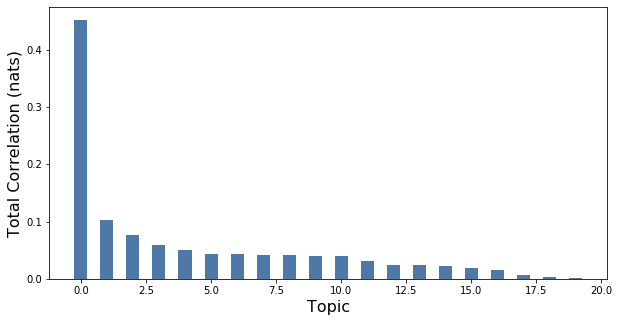

In [123]:
#Selecting number of topics:Choosing from the data visualised
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
#plt.savefig('Distribution of TCs for each topic', dpi=600)

##Pointwise Document TC

In [124]:
topic_model.log_z.shape # n_docs x k_topics

(300000, 20)

In [125]:
print(np.mean(topic_model.log_z, axis=0)) #The pointwise total correlations in log_z represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics
print(topic_model.tcs)

[0.45197722 0.10295922 0.07617104 0.05823997 0.05001377 0.0429463
 0.04276187 0.0423886  0.04202564 0.04049325 0.04044365 0.03084553
 0.02397728 0.02387508 0.02190204 0.01852416 0.01491896 0.00686471
 0.0038792  0.0021012 ]
[0.45197722 0.10295922 0.07617104 0.05823997 0.05001377 0.0429463
 0.04276187 0.0423886  0.04202564 0.04049325 0.04044365 0.03084553
 0.02397728 0.02387508 0.02190204 0.01852416 0.01491896 0.00686471
 0.0038792  0.0021012 ]


##Now adding some hierarchy to the Topic Model

In [0]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=10)
tm_layer3.fit(tm_layer2.labels);

In [0]:
vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')


##Introducing Anchoring in the semi-supervised topic model

In [0]:
# Anchor one word to the eighth topic
anchor_words = ['delivery']

In [0]:
# Anchor the word 'shipping' to the seventh topic
anchored_topic_model = ct.Corex(n_hidden=10, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [100]:
# Print all topics from the CorEx topic model
topics = anchored_topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: easy,use,delivery,easily,read,fast,put,water,time,first
1: one,star,second,season,another,purchases,2nd,rating,investments,third
2: grill,electric,mower,outdoor,black,squirrel,rain,proof,lawn,decker
3: chain,saw,replacement,fits,weber,fit,oregon,perfectly,poulan,pump
4: junk,piece,useless,garbage,mole,crap,totally,completely,total,complete
5: grass,heavy,duty,metal,pruning,shears,detector,fiskars,gets,done
6: recommend,axe,splitting,would,highly,snow,long,expectations,short,recommended
7: money,best,ever,waste,worth,owned,save,market,worst,loves
8: stars,five,four,great,three,good,works,product,love,two
9: like,better,years,get,away,much,bugs,bug,still,flies


In [0]:
#Just look at one of the topics to see the words distributed per topic
topic_words,_ = zip(*anchored_topic_model.get_topics(topic=9))
print('8: ' + ','.join(topic_words))

8: experience,true,expect,buck,complain,folk,person,speak,temper,common


In [0]:
# Anchor words to respective topics, so on...
anchor_words = [['use', 'efficient'], ['shipping', 'delivery'], ['money', 'worth'], ['price', 'quality']]

anchored_topic_model = ct.Corex(n_hidden=10, seed=2) #the best so far for the hidden units that worked is n = 10
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [0]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: use,efficient,extensively,conjunction,exclusively,everytime,everyday,boat,sparingly,jobe
1: shipping,delivery,amazon,review,customer,service,say,order,send,read
2: money,worth,waste,spend,save,penny,investment,cent,earn,pricey
3: price,quality,reasonable,material,beat,reasonably,excellent,value,tag,bargain


In [0]:
# Anchor with single words and groups of words
anchor_words = ['money', ['money', 'cost'], ['money', 'worth'], 'bargain']

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [0]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: money,waste,save,waist,wast,shopvac,preheating,patching,tops,saved
1: money,cost,don,fraction,prohibitive,cheapskate,cram,shows,2010this,whopping
2: money,worth,penny,cent,pricey,pricy,monie,bok,choy,cheapos
3: bargain,high,point,note,mean,level,reviewer,simply,slightly,important


In [0]:
vt.vis_rep(topic_model, column_label=words, prefix='./twenty')

In [0]:
%pwd
%cd /content/
%pwd

/content


'/content'

In [0]:
#Saving the CorEx topics generated in a file
import sys
import csv
with open("corex_topic_improved.txt","w+") as file:
     for n in range(len(anchor_words)):
         topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
         #print('{}: '.format(n) + ','.join(topic_words))
         file.write('{}: '.format(n) + ','.join(topic_words)+'\n')